## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import binarize

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
102657,00027365_003.png,No Finding,3,27365,63,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_011/images/00027365_003.png
25537,00006714_000.png,No Finding,0,6714,28,F,PA,2048,2500,0.171000,0.171000,NaN,/data/images_004/images/00006714_000.png
26462,00006948_015.png,No Finding,15,6948,50,F,AP,2500,2048,0.171000,0.171000,NaN,/data/images_004/images/00006948_015.png
45819,00011724_000.png,No Finding,0,11724,52,F,PA,2886,2693,0.143000,0.143000,NaN,/data/images_006/images/00011724_000.png
23895,00006297_001.png,No Finding,1,6297,46,F,PA,2048,2500,0.168000,0.168000,NaN,/data/images_003/images/00006297_001.png
106301,00028628_000.png,Nodule,0,28628,20,M,PA,2000,1871,0.194311,0.194311,NaN,/data/images_012/images/00028628_000.png
17356,00004663_000.png,No Finding,0,4663,14,F,PA,2048,2500,0.171000,0.171000,NaN,/data/images_003/images/00004663_000.png
76829,00018865_049.png,Effusion|Pneumothorax,49,18865,71,F,PA,2544,3056,0.139000,0.139000,NaN,/data/images_009/images/00018865_049.png
108165,00029276_006.png,No Finding,6,29276,39,M,AP,3056,2544,0.139000,0.139000,NaN,/data/images_012/images/00029276_006.png
41821,00010787_001.png,Emphysema,1,10787,72,F,PA,2646,2603,0.143000,0.143000,NaN,/data/images_005/images/00010787_001.png


In [14]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(20)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
24473,00006439_000.png,No Finding,0,6439,52,F,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
86630,00021374_007.png,Effusion,7,21374,80,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111010,00030287_002.png,No Finding,2,30287,19,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75799,00018609_000.png,No Finding,0,18609,55,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
106445,00028678_000.png,No Finding,0,28678,50,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
91812,00022892_003.png,No Finding,3,22892,71,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
84216,00020702_003.png,No Finding,3,20702,63,F,PA,2536,2772,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4789,00001281_000.png,No Finding,0,1281,43,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
95159,00024873_000.png,No Finding,0,24873,41,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23397,00006202_000.png,No Finding,0,6202,44,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
all_xray_df['path'].head()

0    /data/images_001/images/00000001_000.png
1    /data/images_001/images/00000001_001.png
2    /data/images_001/images/00000001_002.png
3    /data/images_001/images/00000002_000.png
4    /data/images_001/images/00000003_000.png
Name: path, dtype: object

In [16]:
all_xray_df=all_xray_df[all_xray_df['View Position']=='PA']

In [17]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
len(all_xray_df['Image Index'].unique())

67310

In [19]:
len(all_xray_df)

67310

In [20]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

## Create your training and testing data:

In [ ]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    return train_data, val_data

In [21]:

train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [22]:
train_df['Pneumonia'].sum()/len(train_df)

0.009359679096716684

In [23]:

valid_df['Pneumonia'].sum()/len(valid_df)

0.009359679096716684

In [24]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
77572,00019067_001.png,No Finding,1,19067,8,M,PA,2226,2281,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
51787,00013077_015.png,No Finding,15,13077,65,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71591,00017638_000.png,No Finding,0,17638,22,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259,00000057_004.png,Infiltration,4,57,70,M,PA,2734,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19413,00005145_000.png,No Finding,0,5145,51,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
train_df.shape

(53848, 28)

In [26]:
train_df[(train_df['Infiltration']==0) & (train_df['Effusion']==0) & (train_df['Pneumonia']==0) & (train_df['Edema']==0) & (train_df['Atelectasis']==0) ]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
77572,00019067_001.png,No Finding,1,19067,8,M,PA,2226,2281,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
51787,00013077_015.png,No Finding,15,13077,65,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71591,00017638_000.png,No Finding,0,17638,22,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19413,00005145_000.png,No Finding,0,5145,51,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
190,00000039_000.png,No Finding,0,39,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93542,00023465_000.png,No Finding,0,23465,35,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48957,00012413_000.png,Fibrosis|Mass,0,12413,43,F,PA,2510,2991,0.143,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3061,00000809_002.png,No Finding,2,809,41,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28806,00007525_000.png,No Finding,0,7525,49,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
train_df[train_df.Pneumonia==1].shape

(504, 28)

In [28]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
#considering co-occurences might harm the purity of negative class
np_inds = train_df[ (train_df['Pneumonia']==0) ].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [29]:

train_df['Pneumonia'].sum()/len(train_df)

0.5

Assuming 20% prevalence of pneumonia in real world setting

In [30]:
valid_df


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1160,00000285_001.png,Infiltration,1,285,49,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
38769,00010120_025.png,No Finding,25,10120,52,M,PA,2990,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74537,00018294_003.png,Consolidation|Fibrosis|Nodule,3,18294,48,M,PA,2690,2991,0.143000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
94942,00024663_000.png,No Finding,0,24663,46,M,PA,2674,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
94750,00024482_000.png,No Finding,0,24482,25,F,PA,2854,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18481,00004911_000.png,Mass,0,4911,48,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1217,00000310_002.png,No Finding,2,310,60,M,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10918,00002841_001.png,Effusion,1,2841,50,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1590,00000422_007.png,Infiltration,7,422,78,F,PA,2842,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[ (valid_df['Pneumonia']==0) ].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [32]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [33]:
train_df.shape

(1008, 28)

In [34]:
valid_df.shape

(630, 28)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

# Image Data Augmentation

In [ ]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    return val_gen

In [35]:
imgs = train_df.path

In [36]:
imgs

102516    /data/images_011/images/00027320_012.png
2255      /data/images_001/images/00000583_045.png
99639     /data/images_011/images/00026389_002.png
80126     /data/images_009/images/00019690_003.png
25520     /data/images_004/images/00006713_001.png
                            ...                   
94736     /data/images_010/images/00024468_000.png
43335     /data/images_005/images/00011176_003.png
102974    /data/images_011/images/00027449_000.png
83415     /data/images_009/images/00020482_001.png
55773     /data/images_007/images/00013956_000.png
Name: path, Length: 1008, dtype: object

In [37]:
len(imgs)

1008

In [38]:
train_df['Pneumonia_class']=train_df['Pneumonia']

In [39]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
102516,00027320_012.png,Effusion|Infiltration|Pneumonia,12,27320,52,M,PA,2662,2731,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2255,00000583_045.png,Pneumonia,45,583,40,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
99639,00026389_002.png,Pneumonia,2,26389,76,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
80126,00019690_003.png,Effusion|Infiltration|Pneumonia,3,19690,40,M,PA,2990,2948,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25520,00006713_001.png,Atelectasis|Pneumonia,1,6713,72,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [40]:
train_df['Pneumonia_class']=train_df['Pneumonia_class'].replace(1,'YES').replace(0,'NO')

In [41]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
102516,00027320_012.png,Effusion|Infiltration|Pneumonia,12,27320,52,M,PA,2662,2731,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
2255,00000583_045.png,Pneumonia,45,583,40,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
99639,00026389_002.png,Pneumonia,2,26389,76,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
80126,00019690_003.png,Effusion|Infiltration|Pneumonia,3,19690,40,M,PA,2990,2948,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
25520,00006713_001.png,Atelectasis|Pneumonia,1,6713,72,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94736,00024468_000.png,No Finding,0,24468,35,M,PA,2992,2989,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO
43335,00011176_003.png,Atelectasis|Cardiomegaly|Effusion,3,11176,24,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NO
102974,00027449_000.png,No Finding,0,27449,61,F,PA,2914,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO
83415,00020482_001.png,No Finding,1,20482,29,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NO


In [42]:
IMG_SIZE = (224, 224)

In [43]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)



In [44]:
train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 20)
                                         
                                         

Found 1008 validated image filenames belonging to 2 classes.


In [45]:
valid_df['Pneumonia_class']=valid_df['Pneumonia']

In [46]:
valid_df['Pneumonia_class']=valid_df['Pneumonia_class'].replace(1,'YES').replace(0,'NO')

In [47]:
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6)

Found 630 validated image filenames belonging to 2 classes.


In [48]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

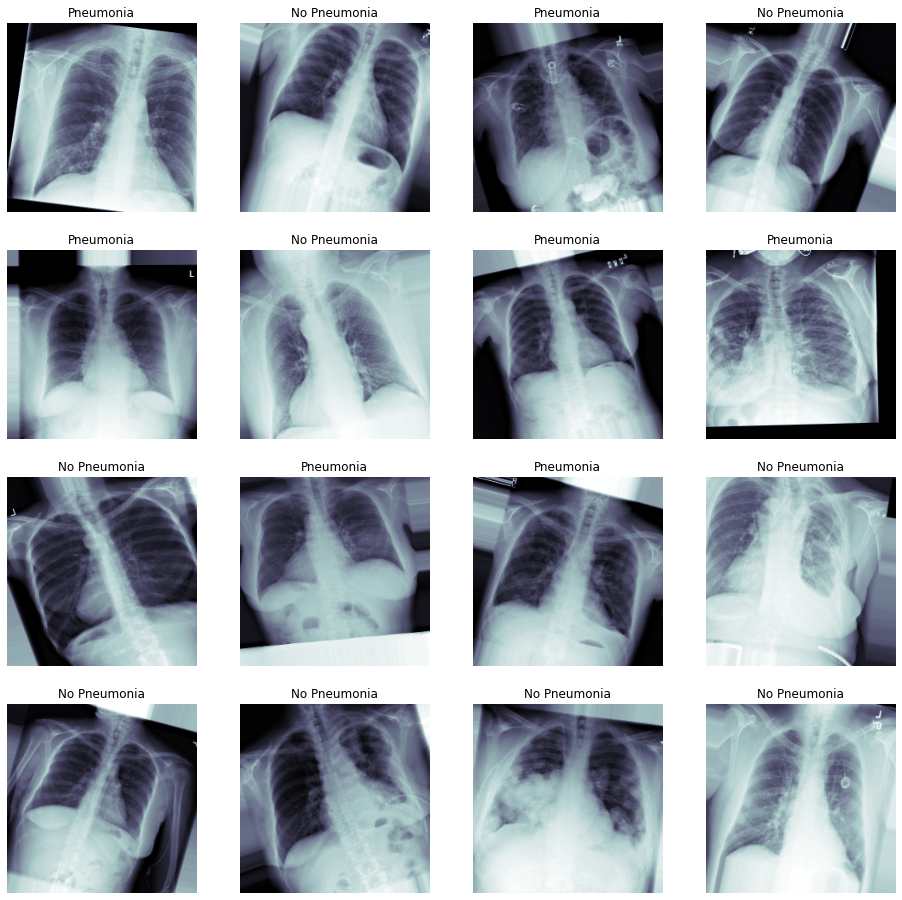

In [49]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

# VGG16

In [ ]:
def load_pretrained_model(vargs):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [50]:

model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [51]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [52]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [53]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [ ]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

# ARCHITECTURE 1

In [54]:

new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [55]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [56]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [134]:
new_model.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 26s 506ms/step - loss: 0.2880 - binary_accuracy: 0.8740 - val_loss: 0.5701 - val_binary_accuracy: 0.8333
Epoch 2/10
51/51 [==============================] - 25s 497ms/step - loss: 0.2989 - binary_accuracy: 0.8641 - val_loss: 1.7392 - val_binary_accuracy: 0.1667
Epoch 3/10
51/51 [==============================] - 25s 494ms/step - loss: 0.3154 - binary_accuracy: 0.8611 - val_loss: 2.2399 - val_binary_accuracy: 0.0000e+00
Epoch 4/10
51/51 [==============================] - 25s 498ms/step - loss: 0.2717 - binary_accuracy: 0.8750 - val_loss: 1.6339 - val_binary_accuracy: 0.0000e+00
Epoch 5/10
51/51 [==============================] - 25s 500ms/step - loss: 0.2865 - binary_accuracy: 0.8750 - val_loss: 2.5084 - val_binary_accuracy: 0.1667
Epoch 6/10
51/51 [==============================] - 25s 498ms/step - loss: 0.2443 - binary_accuracy: 0.8938 - val_loss: 3.4555 - val_binary_accuracy: 0.0000e+00
Epoch 7/10
51/51 [============================

# ARCHITECTURE 2

In [91]:
new_model2 = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model2.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model2.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model2.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model2.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model2.add(Dense(1, activation='sigmoid'))

In [92]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [93]:
new_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [94]:
new_model2.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 26s 518ms/step - loss: 0.6879 - binary_accuracy: 0.5456 - val_loss: 0.7348 - val_binary_accuracy: 0.1667
Epoch 2/10
51/51 [==============================] - 26s 501ms/step - loss: 0.6692 - binary_accuracy: 0.5665 - val_loss: 0.9326 - val_binary_accuracy: 0.1667
Epoch 3/10
51/51 [==============================] - 25s 500ms/step - loss: 0.6385 - binary_accuracy: 0.6210 - val_loss: 0.5356 - val_binary_accuracy: 0.8333
Epoch 4/10
51/51 [==============================] - 26s 505ms/step - loss: 0.6203 - binary_accuracy: 0.6478 - val_loss: 1.0503 - val_binary_accuracy: 0.1667
Epoch 5/10
51/51 [==============================] - 25s 495ms/step - loss: 0.6019 - binary_accuracy: 0.6895 - val_loss: 1.0816 - val_binary_accuracy: 0.0000e+00
Epoch 6/10
51/51 [==============================] - 26s 504ms/step - loss: 0.5814 - binary_accuracy: 0.7014 - val_loss: 1.1513 - val_binary_accuracy: 0.1667
Epoch 7/10
51/51 [==============================] - 26

# ARCHITECTURE 3

In [62]:
new_model3=Sequential()
new_model3.add(Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(224,224,3)))

new_model3.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
new_model3.add(MaxPooling2D(pool_size=(2,2)))
new_model3.add(Dropout(0.25))

new_model3.add(Flatten())
new_model3.add(Dense(64, activation='relu'))
new_model3.add(Dropout(0.5))


new_model3.add(Dense(1, activation='sigmoid'))


In [63]:
new_model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [64]:
new_model3.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 10)

Epoch 1/10
51/51 [==============================] - 26s 510ms/step - loss: 0.7154 - binary_accuracy: 0.4881 - val_loss: 0.6926 - val_binary_accuracy: 1.0000
Epoch 2/10
51/51 [==============================] - 24s 477ms/step - loss: 0.6932 - binary_accuracy: 0.4940 - val_loss: 0.6934 - val_binary_accuracy: 0.0000e+00
Epoch 3/10
51/51 [==============================] - 25s 482ms/step - loss: 0.6932 - binary_accuracy: 0.4861 - val_loss: 0.6934 - val_binary_accuracy: 0.0000e+00
Epoch 4/10
51/51 [==============================] - 25s 481ms/step - loss: 0.6932 - binary_accuracy: 0.4772 - val_loss: 0.6934 - val_binary_accuracy: 0.0000e+00
Epoch 5/10
51/51 [==============================] - 25s 488ms/step - loss: 0.6932 - binary_accuracy: 0.4990 - val_loss: 0.6935 - val_binary_accuracy: 0.0000e+00
Epoch 6/10
51/51 [==============================] - 24s 478ms/step - loss: 0.6931 - binary_accuracy: 0.5188 - val_loss: 0.6931 - val_binary_accuracy: 0.3333
Epoch 7/10
51/51 [========================

# Taking Architecture 1

In [119]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_new_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [120]:
weight_path

'xray_class_new_model.best.hdf5'

### Start training! 

In [121]:
## train your model

# Todo

history = new_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list)

Epoch 1/10
51/51 [==============================] - 26s 505ms/step - loss: 0.3792 - binary_accuracy: 0.8353 - val_loss: 0.8014 - val_binary_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 0.80137, saving model to xray_class_new_model.best.hdf5
Epoch 2/10
51/51 [==============================] - 25s 494ms/step - loss: 0.3249 - binary_accuracy: 0.8532 - val_loss: 2.4227 - val_binary_accuracy: 0.1667

Epoch 00002: val_loss did not improve from 0.80137
Epoch 3/10
51/51 [==============================] - 25s 500ms/step - loss: 0.3542 - binary_accuracy: 0.8433 - val_loss: 2.0122 - val_binary_accuracy: 0.3333

Epoch 00003: val_loss did not improve from 0.80137
Epoch 4/10
51/51 [==============================] - 25s 489ms/step - loss: 0.3251 - binary_accuracy: 0.8591 - val_loss: 1.5101 - val_binary_accuracy: 0.1667

Epoch 00004: val_loss did not improve from 0.80137
Epoch 5/10
51/51 [==============================] - 26s 500ms/step - loss: 0.3051 - binary_accuracy: 0.8700 - val_lo

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [122]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 0s 24ms/step


In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [88]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

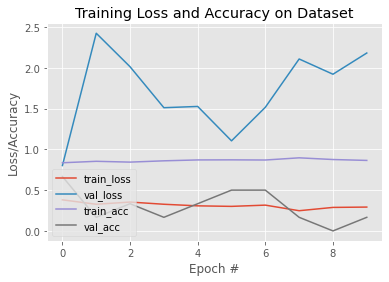

In [123]:

plot_history(history)

#  Taking Architecture 2

In [124]:
weight_path2="{}_new_model2.best.hdf5".format('xray_class')

checkpoint2 = ModelCheckpoint(weight_path2, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early2 = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list2 = [checkpoint2, early2]

In [125]:
weight_path2

'xray_class_new_model2.best.hdf5'

In [126]:
history2 = new_model2.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list2)

Epoch 1/10
51/51 [==============================] - 26s 509ms/step - loss: 0.3735 - binary_accuracy: 0.8433 - val_loss: 1.0096 - val_binary_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.00963, saving model to xray_class_new_model2.best.hdf5
Epoch 2/10
51/51 [==============================] - 25s 497ms/step - loss: 0.3940 - binary_accuracy: 0.8185 - val_loss: 1.5095 - val_binary_accuracy: 0.1667

Epoch 00002: val_loss did not improve from 1.00963
Epoch 3/10
51/51 [==============================] - 26s 503ms/step - loss: 0.3960 - binary_accuracy: 0.8254 - val_loss: 1.8312 - val_binary_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.00963
Epoch 4/10
51/51 [==============================] - 26s 507ms/step - loss: 0.3881 - binary_accuracy: 0.8254 - val_loss: 0.4012 - val_binary_accuracy: 1.0000

Epoch 00004: val_loss improved from 1.00963 to 0.40123, saving model to xray_class_new_model2.best.hdf5
Epoch 5/10
51/51 [==============================] - 26s 50

In [127]:
new_model2.load_weights(weight_path2)
pred_Y2 = new_model2.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 0s 24ms/step


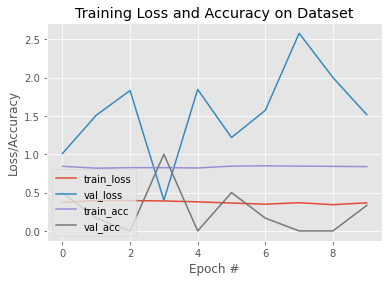

In [128]:
plot_history(history2)

# Taking Architecture 3

In [129]:
weight_path3="{}_new_model3.best.hdf5".format('xray_class')

checkpoint3 = ModelCheckpoint(weight_path3, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early3 = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list3 = [checkpoint3, early3]

In [130]:
history3 = new_model3.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =10 , 
                          callbacks = callbacks_list3)

Epoch 1/10
51/51 [==============================] - 25s 491ms/step - loss: 0.6930 - binary_accuracy: 0.5407 - val_loss: 0.7122 - val_binary_accuracy: 0.1667

Epoch 00001: val_loss improved from inf to 0.71220, saving model to xray_class_new_model3.best.hdf5
Epoch 2/10
51/51 [==============================] - 25s 492ms/step - loss: 0.6917 - binary_accuracy: 0.5198 - val_loss: 0.7059 - val_binary_accuracy: 0.3333

Epoch 00002: val_loss improved from 0.71220 to 0.70587, saving model to xray_class_new_model3.best.hdf5
Epoch 3/10
51/51 [==============================] - 25s 487ms/step - loss: 0.6931 - binary_accuracy: 0.5030 - val_loss: 0.7041 - val_binary_accuracy: 0.1667

Epoch 00003: val_loss improved from 0.70587 to 0.70408, saving model to xray_class_new_model3.best.hdf5
Epoch 4/10
51/51 [==============================] - 25s 488ms/step - loss: 0.6919 - binary_accuracy: 0.5218 - val_loss: 0.7000 - val_binary_accuracy: 0.3333

Epoch 00004: val_loss improved from 0.70408 to 0.70000, savi

In [131]:
new_model3.load_weights(weight_path3)
pred_Y3 = new_model3.predict(valX, batch_size = 32, verbose = True)

6/6 [==============================] - 0s 4ms/step


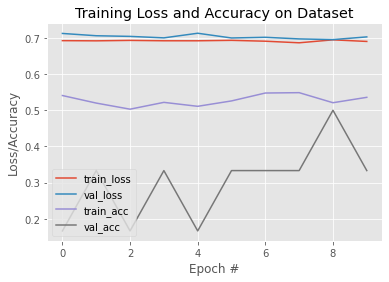

In [132]:
plot_history(history3)

# AUC PLOTS

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)